In [21]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [3]:
# Create training and test dataloaders

num_workers = 0
# setting num_workers to a positive number would spawn that many data_loader processes, and use the multiple processes created to load the data. This way computation of the main code doesn't stop

# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

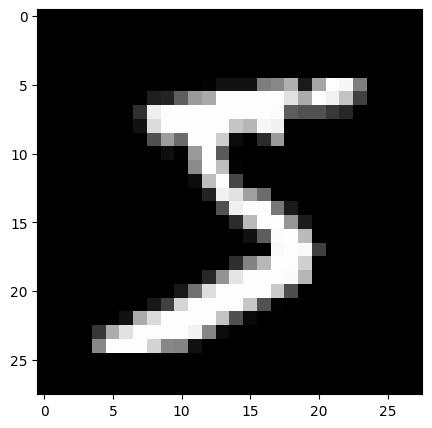

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) #common mistake is using dataiter.next() which doesn't work anymore
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [6]:
from torch import nn as nn

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parameters of simple tractable normal distribution "q"

        return mean, log_var

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [9]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [10]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [11]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

Start training VAE...
	Epoch 1 complete! 	Average Loss:  30.341860522110885
	Epoch 2 complete! 	Average Loss:  24.052901366699057
	Epoch 3 complete! 	Average Loss:  23.05214013150868
	Epoch 4 complete! 	Average Loss:  22.597753999054373
	Epoch 5 complete! 	Average Loss:  22.29850421250443
	Epoch 6 complete! 	Average Loss:  22.038148976090987
	Epoch 7 complete! 	Average Loss:  21.864714141367436
	Epoch 8 complete! 	Average Loss:  21.745814393372008
	Epoch 9 complete! 	Average Loss:  21.64015942366531
	Epoch 10 complete! 	Average Loss:  21.55942556942809
	Epoch 11 complete! 	Average Loss:  21.49709444245087
	Epoch 12 complete! 	Average Loss:  21.438420193612714
	Epoch 13 complete! 	Average Loss:  21.3828871721075
	Epoch 14 complete! 	Average Loss:  21.33117605038268
	Epoch 15 complete! 	Average Loss:  21.2900969712072
	Epoch 16 complete! 	Average Loss:  21.267699725592124
	Epoch 17 complete! 	Average Loss:  21.22999732536171
	Epoch 18 complete! 	Average Loss:  21.19074416488439
	Epoch 19

Generating images from noise

In [13]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

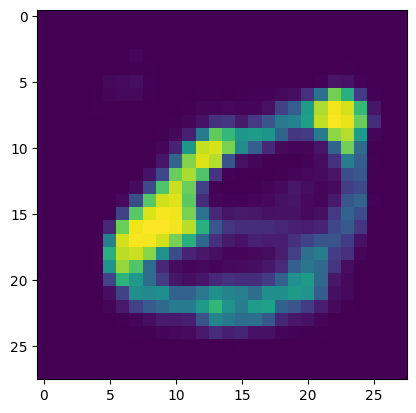

In [15]:
show_image(generated_images, idx=12)


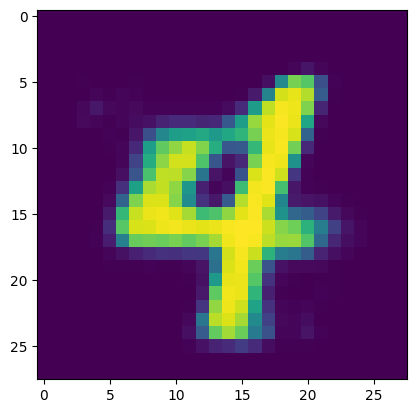

In [16]:
show_image(generated_images, idx=10)


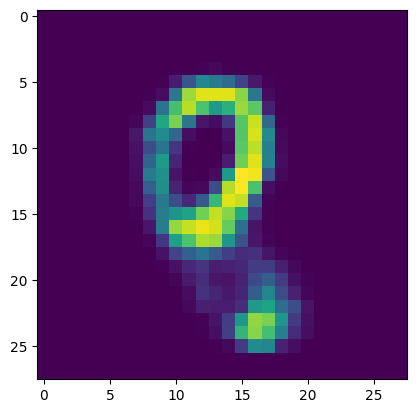

In [17]:
show_image(generated_images, idx=16)


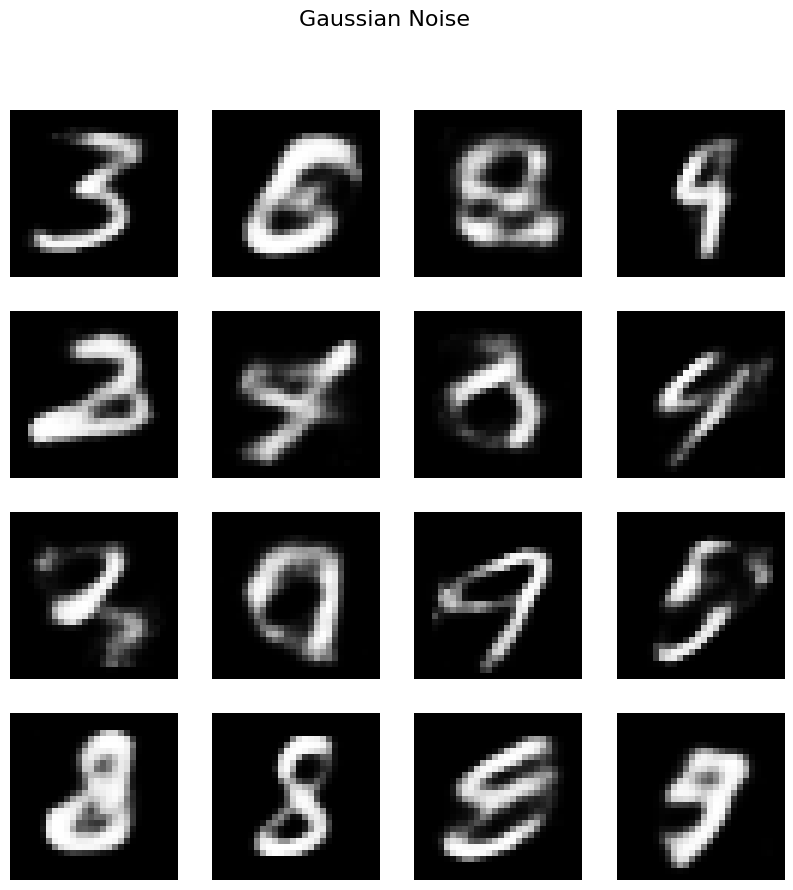

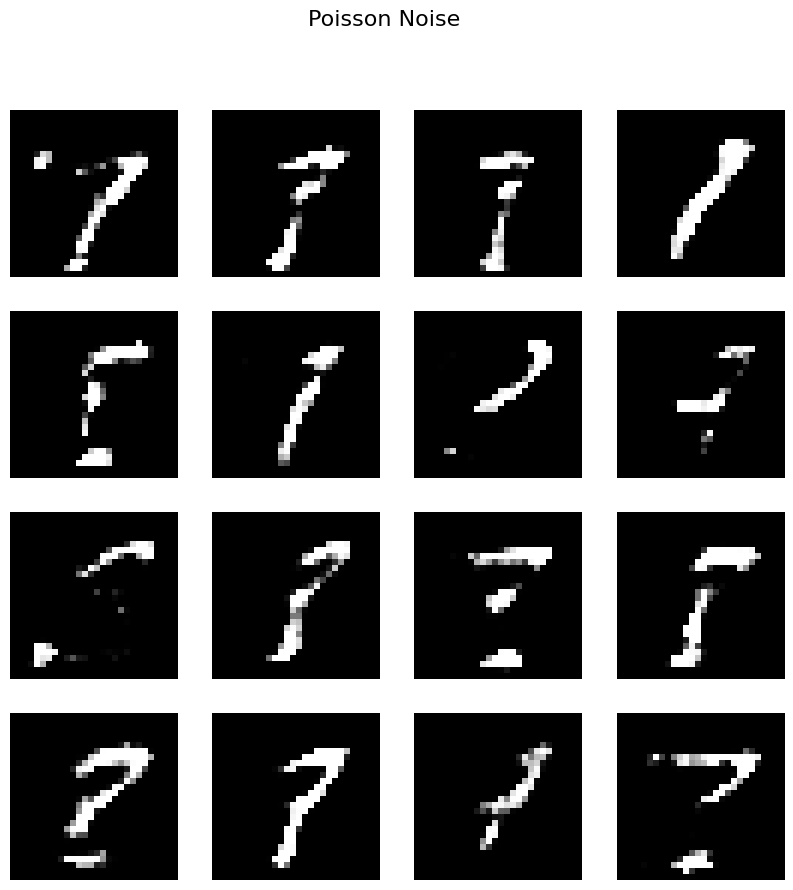

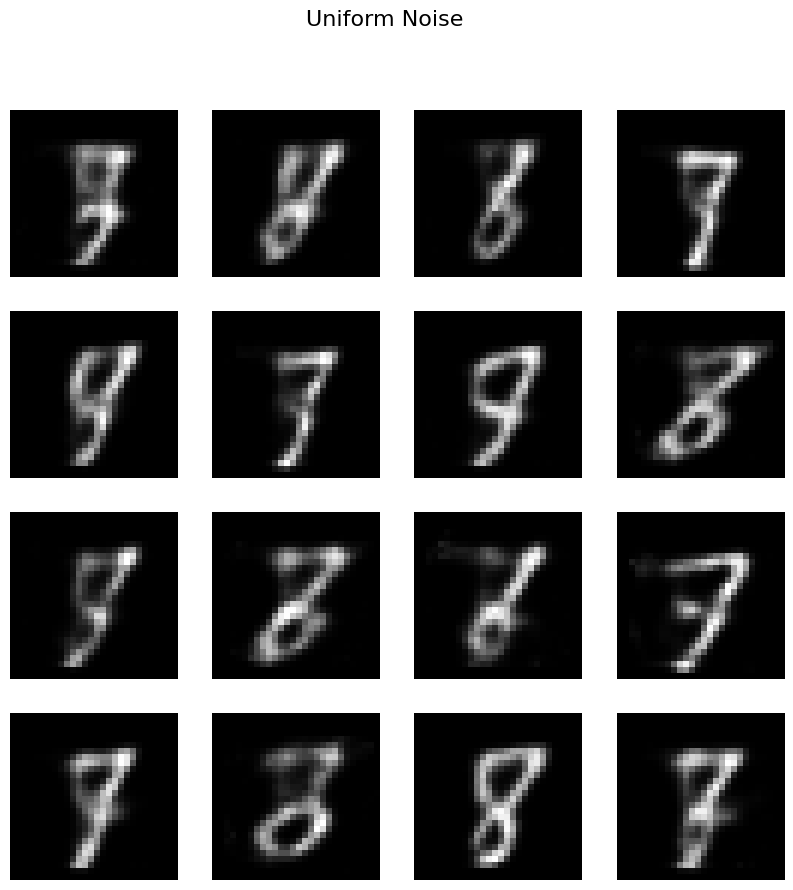

In [20]:
def visualize_images(images, title, n_rows=4, n_cols=4, image_size=(28, 28)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        img_reshaped = img.view(image_size).cpu().numpy()
        ax.imshow(img_reshaped, cmap='gray')
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

with torch.no_grad():
    # Gaussian Noise
    gaussian_noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images_gaussian = decoder(gaussian_noise)
    visualize_images(generated_images_gaussian, title="Gaussian Noise")

    # Poisson Noise
    poisson_noise = torch.poisson(torch.rand(batch_size, latent_dim) * 10).to(DEVICE)
    generated_images_poisson = decoder(poisson_noise)
    visualize_images(generated_images_poisson, title="Poisson Noise")

    # Uniform Noise
    uniform_noise = torch.rand(batch_size, latent_dim).to(DEVICE)
    generated_images_uniform = decoder(uniform_noise)
    visualize_images(generated_images_uniform, title="Uniform Noise")
